In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import string
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import sys
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader=SentimentIntensityAnalyzer()

In [2]:
APR_dataframe=pd.read_csv("C:/Users/jasan/OneDrive/Desktop/APR.csv")

In [3]:
APR_dataframe.rename(columns = {'ProductId':'Product_ID', 'UserId':'User_ID','HelpfulnessNumerator':'Help_num','HelpfulnessDenominator':'Help_denom','Score':'Ratings','Text':'Comments'}, inplace = True)

EXPLORATORY DATA ANALYSIS

#Checking Null values

In [4]:
APR_dataframe.isnull().sum()

Id              0
Product_ID      0
User_ID         0
ProfileName    16
Help_num        0
Help_denom      0
Ratings         0
Time            0
Summary        27
Comments        0
dtype: int64

#Dropping null values

In [5]:
mainframe=APR_dataframe.dropna()

DATA CLEANING PROCESS

#Removing @ and punctuation from the column Summary and Comments

In [6]:
def cleancomments (text):
    text = re.sub (r'@[A-Za-z0-9]+', '',text)  #remove @
    text = re.sub ('[^\w\s]', '',text) 
    return text

In [7]:
mainframe['Comments']=mainframe['Comments'].apply(cleancomments)
mainframe['Summary']=mainframe['Summary'].apply(cleancomments)

In [8]:
stop= stopwords.words('english')
mainframe['Comments']=mainframe['Comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stop= stopwords.words('english')
mainframe['Summary']=mainframe['Summary'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Converting the entire column of summary and comments to lower case

In [9]:
mainframe['Comments']=mainframe['Comments'].str.lower()
mainframe['Summary']=mainframe['Summary'].str.lower()

#Converting the entire column of summary and comments to String

In [10]:
mainframe['Comments']=mainframe['Comments'].astype(str)
mainframe['Summary']=mainframe['Summary'].astype(str)

#Creating tokens

In [11]:
def CommentsTokenize(Comments):
    tokenize = nltk.word_tokenize(Comments)
    return [g for g in tokenize if g.isalpha()]

In [12]:
mainframe['Comments_Tokens']=mainframe['Comments'].apply(CommentsTokenize)

In [13]:
text_blob=mainframe

#Calculating polarity and subjectivity for each comment in the Comments column

In [14]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def polarity(text):
    return TextBlob(text).sentiment.polarity
text_blob['Subjectivity']=text_blob['Comments'].apply(subjectivity)
text_blob['Ploarity']=text_blob['Comments'].apply(polarity)

#Based on the polarity score, we are deriving the sentiment of comments into a positive, negative, or neutral value.

In [15]:
def polanalysis(score):
    if score<0:
        return 'Negative'
    elif score==0:
        return 'Neutral'
    else:
        return 'Positive'
text_blob['Textblob_Analysis']= text_blob['Ploarity'].apply(polanalysis)

#Based on Ratings provided from the user, We are deriving positive, negative, or neutral value.

In [16]:
def ratingsanalysis(Ratings):
    if Ratings<3:
        return 'Negative'
    if Ratings==3:
        return 'Neutral'
    if Ratings>3:
        return 'Positive'
text_blob['Ratings_Analysis']=text_blob['Ratings'].apply(ratingsanalysis)

#Now we are using Vader Sentiment Analysis.

In [17]:
vader_data=mainframe

In [18]:
temp_data=[]
for row in vader_data['Comments']:
    ab= vader.polarity_scores(row)
    temp_data.append(ab)
vader_new=pd.DataFrame(temp_data)

#Based on the compound value, we are deriving sentiment of comments into a positive, negative, or neutral value.

In [19]:
def vaderanalysis(compound):
    if compound<0:
        return 'Negative'
    elif compound==0:
        return 'Neutral'
    else:
        return 'Positive'
vader_new['Vader_Analysis']= vader_new['compound'].apply(vaderanalysis)

In [20]:
vader_new=vader_new.drop(columns=['neg','neu','pos'])

In [21]:
new_combined_data= pd.concat([text_blob.reset_index(drop=True), vader_new], axis=1)

#We are calculating the percentage of positive, negative, and neutral values in textblob analysis.

In [22]:
(new_combined_data['Textblob_Analysis'].value_counts()/new_combined_data['Textblob_Analysis'].count())*100

Positive    87.316924
Negative    10.784978
Neutral      1.898098
Name: Textblob_Analysis, dtype: float64

#We are calculating the percentage of positive, negative, and neutral values in Ratings analysis.

In [23]:
(new_combined_data['Ratings_Analysis'].value_counts()/new_combined_data['Ratings_Analysis'].count())*100

Positive    78.071325
Negative    14.427413
Neutral      7.501262
Name: Ratings_Analysis, dtype: float64

#We are calculating the percentage of positive, negative, and neutral values in Vader analysis.

In [24]:
(new_combined_data['Vader_Analysis'].value_counts()/new_combined_data['Vader_Analysis'].count())*100

Positive    90.225910
Negative     8.385833
Neutral      1.388256
Name: Vader_Analysis, dtype: float64

#Creating Pie Chart

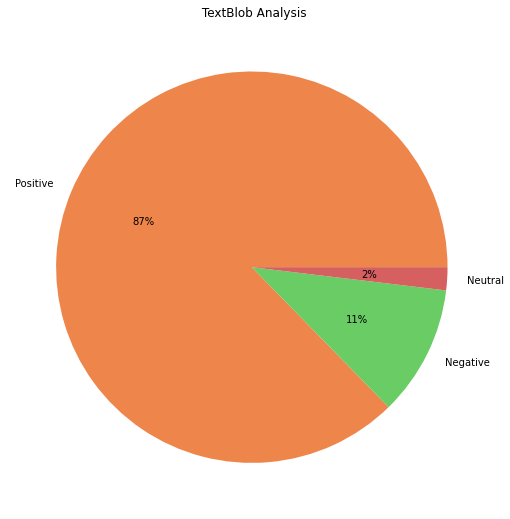

In [25]:
Pie_TB= new_combined_data['Textblob_Analysis'].value_counts(normalize = True)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title(" TextBlob Analysis")
Chart_color = sns.color_palette('muted')[1:9]
plt.pie(Pie_TB, labels = ["Positive","Negative","Neutral"], colors=Chart_color,autopct='%.0f%%')
plt.show()

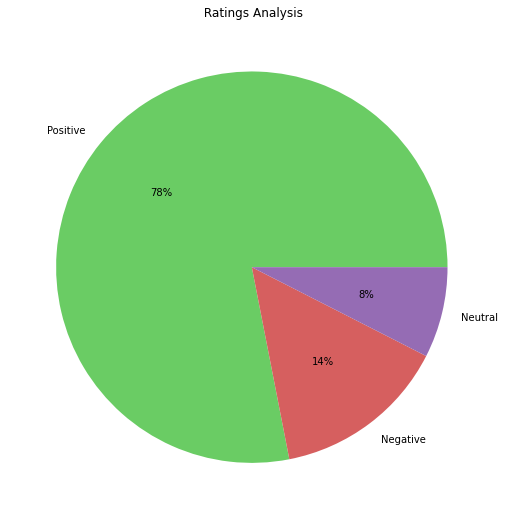

In [26]:
Pie_R= new_combined_data['Ratings_Analysis'].value_counts(normalize = True)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title(" Ratings Analysis")
Chart_color = sns.color_palette('muted')[2:6]
plt.pie(Pie_R, labels = ["Positive","Negative","Neutral"], colors=Chart_color,autopct='%.0f%%')
plt.show()

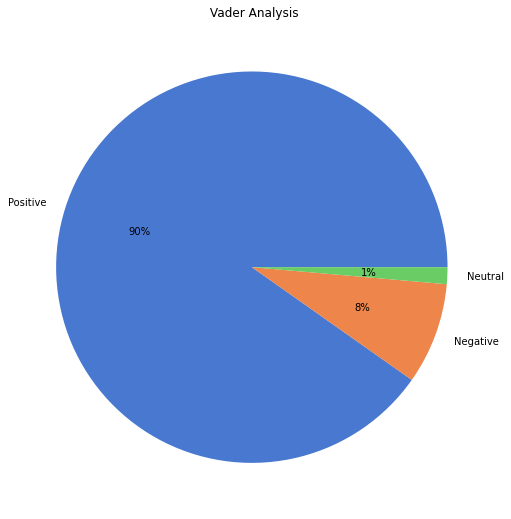

In [27]:
Pie_VA= new_combined_data['Vader_Analysis'].value_counts(normalize = True)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title(" Vader Analysis")
Chart_color = sns.color_palette('muted')[0:9]
plt.pie(Pie_VA, labels = ["Positive","Negative","Neutral"], colors=Chart_color,autopct='%.0f%%')
plt.show()

#Creating Bar Chart and representing counts.

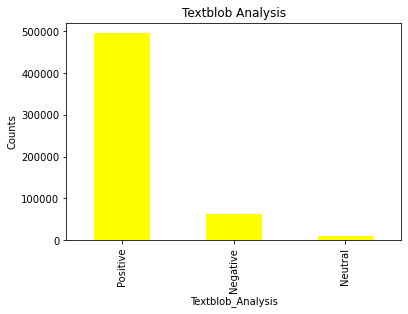

In [28]:
new_combined_data['Textblob_Analysis'].value_counts()
plt.title('Textblob Analysis')
plt.xlabel('Textblob_Analysis')
plt.ylabel('Counts')
new_combined_data['Textblob_Analysis'].value_counts().plot(kind='bar',color='yellow')
plt.show()

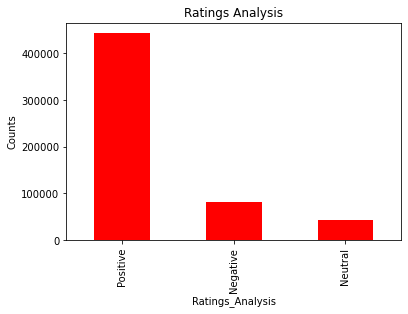

In [29]:
new_combined_data['Ratings_Analysis'].value_counts()
plt.title('Ratings Analysis')
plt.xlabel('Ratings_Analysis')
plt.ylabel('Counts')
new_combined_data['Ratings_Analysis'].value_counts().plot(kind='bar', color='red')
plt.show()

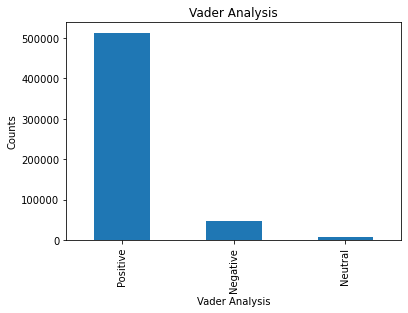

In [30]:
new_combined_data['Vader_Analysis'].value_counts()
plt.title('Vader Analysis')
plt.xlabel('Vader Analysis')
plt.ylabel('Counts')
new_combined_data['Vader_Analysis'].value_counts().plot(kind='bar')
plt.show()

#Heat Map

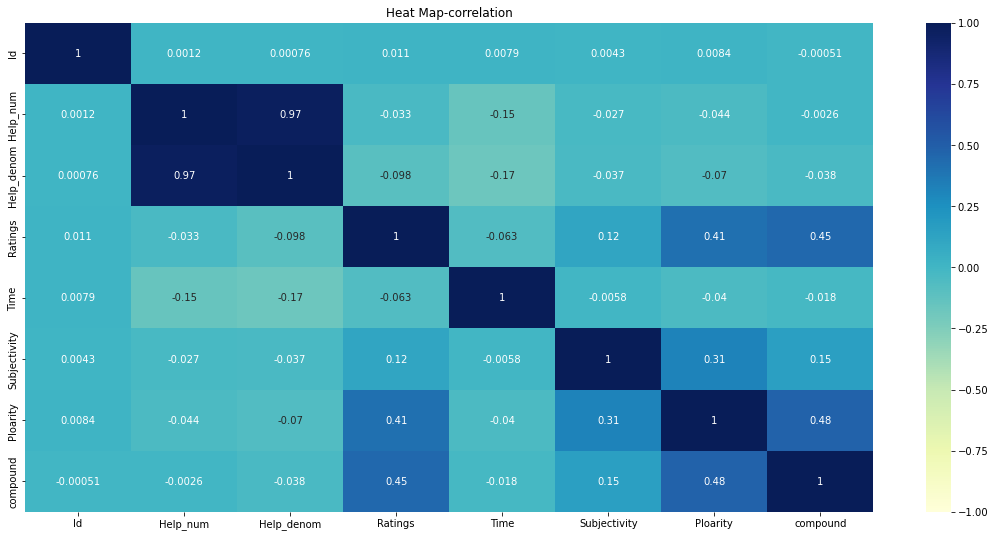

In [31]:
plt.figure(figsize=(19,9))
plot=sns.heatmap(new_combined_data.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")
plot.set_title("Heat Map-correlation")
plt.show()

#WORDCLOUD VISUALIZATION

In [32]:
wordcloud_data=new_combined_data.Summary.str.cat()

<function matplotlib.pyplot.show(close=None, block=None)>

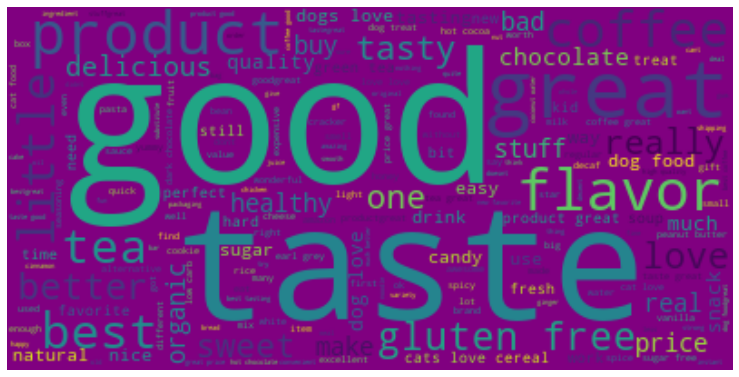

In [33]:
wordcloud=WordCloud(background_color='purple').generate(wordcloud_data)
plt.figure(figsize=(13,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show

In [34]:
wordcloud_neg = new_combined_data[new_combined_data['Ratings'].isin([1,2]) ]
wordcloud_pos = new_combined_data[new_combined_data['Ratings'].isin([4,5]) ]
wordcloud_neg_str = wordcloud_neg.Summary.str.cat()
wordcloud_pos_str = wordcloud_pos.Summary.str.cat()

Text(0.5, 1.0, 'Negative Reviews')

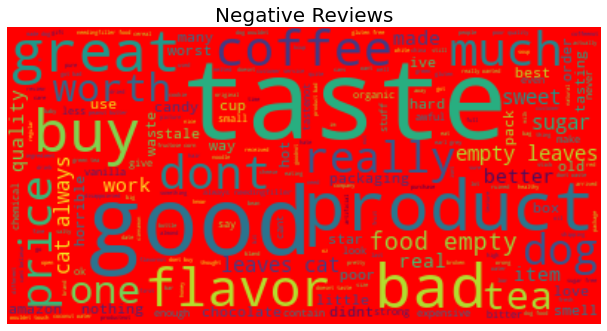

In [35]:
wordcloud_negative = WordCloud(background_color='red').generate(wordcloud_neg_str)
wordcloud_positive = WordCloud(background_color='black').generate(wordcloud_pos_str)
# Negative comments plot
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(212)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Negative Reviews',fontsize=20)

Text(0.5, 1.0, 'Positive Reviews')

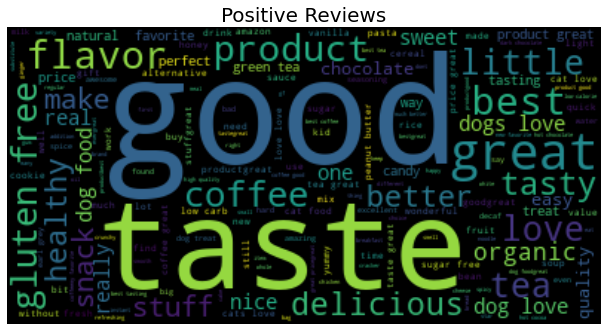

In [36]:
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(212)
ax1.imshow(wordcloud_positive,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Positive Reviews',fontsize=20)

#FEATURE ENGINEERING

In [37]:
model_data=new_combined_data

In [38]:
model_data=model_data.drop(columns=['Id','Product_ID','User_ID','ProfileName','Help_num','Help_denom','Ratings','Time','Subjectivity','Ploarity','compound'])

In [39]:
model_data= model_data[model_data['Textblob_Analysis'] != 'Neutral']
model_data= model_data[model_data['Vader_Analysis'] != 'Neutral']

In [40]:
Textblob_model=model_data

In [41]:
Textblob_model=Textblob_model.drop(columns=['Comments_Tokens','Ratings_Analysis','Vader_Analysis'])

In [42]:
def Sentiment(Textblob_Analysis):
    if Textblob_Analysis == 'Negative':
        return 0
    else:
        return 1
    
Textblob_model['Textblob_Analysis_Sentiment']= Textblob_model['Textblob_Analysis'].apply(Sentiment)

In [43]:
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_curve
import scikitplot as skplt

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Textblob_model['Comments'], Textblob_model['Textblob_Analysis_Sentiment'],random_state=34, test_size=0.2, shuffle=True)

In [45]:
X_train.shape, X_test.shape

((441817,), (110455,))

In [46]:
y_train.shape,y_test.shape

((441817,), (110455,))

#We are using the TF-IDF ON Comments column and transforming it to numerical values.

In [47]:
from joblib import parallel_backend
with parallel_backend('threading', n_jobs=-1):
    tfidf_tb = TfidfVectorizer()
    X_train_tfidf_tb = tfidf_tb.fit_transform(X_train)

In [48]:
X_test_tfidf_tb = tfidf_tb.transform(X_test.astype('U'))

ML ALGORITHM XGBOOST

In [49]:
from xgboost import XGBClassifier

In [50]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_tfidf_tb, y_train)
xgboost_pred = xgboost_model.predict(X_test_tfidf_tb)
print(xgboost_pred)

[1 1 1 ... 1 1 1]


In [51]:
xgboost_accuracy=accuracy_score(y_test,xgboost_pred)

In [52]:
print("XGBoost Accuracy for Textblob Analysis is:",xgboost_accuracy*100)

XGBoost Accuracy for Textblob Analysis is: 95.14915576479109


Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
Decisiontree_model= DecisionTreeClassifier(random_state=34, max_depth=80)

In [55]:
Decisiontree_model.fit(X_train_tfidf_tb,y_train)

DecisionTreeClassifier(max_depth=80, random_state=34)

In [56]:
Decisiontree_pred = Decisiontree_model.predict(X_test_tfidf_tb)

In [57]:
Decisiontree_accuracy=accuracy_score(y_test,Decisiontree_pred)

In [58]:
print("Decision Tree Accuracy for Textblob Analysis is:",Decisiontree_accuracy*100)

Decision Tree Accuracy for Textblob Analysis is: 94.28907699968313


Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
Randomforest_model= RandomForestClassifier(n_estimators=90, max_depth=150)

In [61]:
Randomforest_model.fit(X_train_tfidf_tb,y_train)

RandomForestClassifier(max_depth=150, n_estimators=90)

In [62]:
randomtree_pred=Randomforest_model.predict(X_test_tfidf_tb)

In [63]:
Randomtree_accuracy=accuracy_score(y_test,randomtree_pred)

In [64]:
print("Random Tree Accuracy for Textblob Analysis is:",Randomtree_accuracy*100)

Random Tree Accuracy for Textblob Analysis is: 92.13254266443349


ML for Vader

In [65]:
Vader_model=model_data

In [66]:
Vader_model=Vader_model.drop(columns=['Comments_Tokens','Ratings_Analysis','Textblob_Analysis'])

In [67]:
def Sentiment_vader(Vader_Analysis):
    if Vader_Analysis == 'Negative':
        return 0
    else:
        return 1
    
Vader_model['Vader_Analysis_Sentiment']= Vader_model['Vader_Analysis'].apply(Sentiment_vader)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(Vader_model['Comments'], Vader_model['Vader_Analysis_Sentiment'],random_state=34, test_size=0.2, shuffle=True)

In [69]:
from joblib import parallel_backend
with parallel_backend('threading', n_jobs=-1):
    tfidf_v = TfidfVectorizer()
    X_train_tfidf_v = tfidf_v.fit_transform(X_train)

In [70]:
X_test_tfidf_v = tfidf_v.transform(X_test.astype('U'))

ML ALGORITHMS FOR VADER ANALYSIS

In [71]:
xgboost_model_v = XGBClassifier()

In [72]:
xgboost_model_v.fit(X_train_tfidf_v, y_train)
xgboost_pred_v = xgboost_model_v.predict(X_test_tfidf_v)

In [73]:
xgboost_accuracy_v=accuracy_score(y_test,xgboost_pred_v)

In [74]:
print("XGBoost Accuracy for Vader Analysis is:",xgboost_accuracy_v*100)

XGBoost Accuracy for Vader Analysis is: 94.55343805169527


Decision Tree

In [75]:
Decisiontree_model_v= DecisionTreeClassifier(random_state=34, max_depth=80)

In [76]:
Decisiontree_model_v.fit(X_train_tfidf_v,y_train)

DecisionTreeClassifier(max_depth=80, random_state=34)

In [77]:
Decisiontree_pred_v = Decisiontree_model_v.predict(X_test_tfidf_v)

In [78]:
decisiontree_accuracy_v=accuracy_score(Decisiontree_pred_v,y_test)

In [79]:
print("Decision Tree Accuracy for Vader Analysis is:",decisiontree_accuracy_v*100)

Decision Tree Accuracy for Vader Analysis is: 94.26101127155854


Random Forest

In [80]:
Randomforest_model_v= RandomForestClassifier(n_estimators=90, max_depth=150)

In [81]:
Randomforest_model_v.fit(X_train_tfidf_v,y_train)

RandomForestClassifier(max_depth=150, n_estimators=90)

In [82]:
Randomforest_pred_v = Randomforest_model_v.predict(X_test_tfidf_v)

In [83]:
Randomforest_accuracy_v=accuracy_score(Randomforest_pred_v,y_test)

In [84]:
print("Random Forest Accuracy for Vader Analysis is:",Randomforest_accuracy_v*100)

Random Forest Accuracy for Vader Analysis is: 93.52224887963423


CONCLUSION: COMPARING ALL MACHINE LEARNING MODELS

In [85]:
ml_models=['XGBoost','DecisioN Tree','Random Forest']
Textblob=[xgboost_accuracy*100,Decisiontree_accuracy*100,Randomtree_accuracy*100]
vader=[xgboost_accuracy_v*100,decisiontree_accuracy_v*100,Randomforest_accuracy_v*100]

In [86]:
Comparison=pd.DataFrame({'ML Models':ml_models,'TB_Accuracy':Textblob,'Vader_Accuracy':vader})
Comparison

,ML Models,TB_Accuracy,Vader_Accuracy
0,XGBoost,95.149156,94.553438
1,DecisioN Tree,94.289077,94.261011
2,Random Forest,92.132543,93.522249
